In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import os,sys
from pandas.plotting import scatter_matrix 

rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)


from scripts.utils import (
    detect_outliers_iqr,
    plot_time_series, 
    plot_correlation_analysis, 
    plot_wind_analysis, 
    plot_temperature_analysis, 
    plot_histograms, 
    calculate_z_scores, 
    plot_bubble_chart, 
    clean_dataset
)


Reading The Data from CSV

In [3]:
togo_df = pd.read_csv('../Data/togo-dapaong_qc.csv')
togo_df.head(10)

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-10-25 00:01,-1.3,0.0,0.0,0.0,0.0,24.8,94.5,0.9,1.1,0.4,227.6,1.1,977,0,0.0,24.7,24.4,NaN
1,2021-10-25 00:02,-1.3,0.0,0.0,0.0,0.0,24.8,94.4,1.1,1.6,0.4,229.3,0.7,977,0,0.0,24.7,24.4,NaN
2,2021-10-25 00:03,-1.3,0.0,0.0,0.0,0.0,24.8,94.4,1.2,1.4,0.3,228.5,2.9,977,0,0.0,24.7,24.4,NaN
3,2021-10-25 00:04,-1.2,0.0,0.0,0.0,0.0,24.8,94.3,1.2,1.6,0.3,229.1,4.6,977,0,0.0,24.7,24.4,NaN
4,2021-10-25 00:05,-1.2,0.0,0.0,0.0,0.0,24.8,94.0,1.3,1.6,0.4,227.5,1.6,977,0,0.0,24.7,24.4,NaN
5,2021-10-25 00:06,-1.2,0.0,0.0,0.0,0.0,24.9,93.9,1.2,1.4,0.3,226.2,4.8,977,0,0.0,24.8,24.5,NaN
6,2021-10-25 00:07,-1.1,0.0,0.0,0.0,0.0,24.9,93.8,1.2,1.4,0.3,226.4,0.9,977,0,0.0,24.8,24.5,NaN
7,2021-10-25 00:08,-1.1,0.0,0.0,0.0,0.0,24.9,93.7,1.1,1.4,0.3,224.5,2.8,977,0,0.0,24.8,24.5,NaN
8,2021-10-25 00:09,-1.1,0.0,0.0,0.0,0.0,24.9,93.6,1.0,1.4,0.3,225.6,4.1,977,0,0.0,24.8,24.5,NaN
9,2021-10-25 00:10,-1.1,0.0,0.0,0.0,0.0,24.9,93.4,0.9,1.4,0.4,231.5,0.9,977,0,0.0,24.8,24.5,NaN


In [4]:
togo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525600 entries, 0 to 525599
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Timestamp      525600 non-null  object 
 1   GHI            525600 non-null  float64
 2   DNI            525600 non-null  float64
 3   DHI            525600 non-null  float64
 4   ModA           525600 non-null  float64
 5   ModB           525600 non-null  float64
 6   Tamb           525600 non-null  float64
 7   RH             525600 non-null  float64
 8   WS             525600 non-null  float64
 9   WSgust         525600 non-null  float64
 10  WSstdev        525600 non-null  float64
 11  WD             525600 non-null  float64
 12  WDstdev        525600 non-null  float64
 13  BP             525600 non-null  int64  
 14  Cleaning       525600 non-null  int64  
 15  Precipitation  525600 non-null  float64
 16  TModA          525600 non-null  float64
 17  TModB          525600 non-nul

cheaking missing values

In [6]:
togo_df.isnull().sum()

Timestamp             0
GHI                   0
DNI                   0
DHI                   0
ModA                  0
ModB                  0
Tamb                  0
RH                    0
WS                    0
WSgust                0
WSstdev               0
WD                    0
WDstdev               0
BP                    0
Cleaning              0
Precipitation         0
TModA                 0
TModB                 0
Comments         525600
dtype: int64

Checking for wrong entries like symbols -,?,#,*,etc

In [7]:
for col in togo_df.columns:
    print('{} : {}'.format(col,togo_df[col].unique()))

Timestamp : ['2021-10-25 00:01' '2021-10-25 00:02' '2021-10-25 00:03' ...
 '2022-10-24 23:58' '2022-10-24 23:59' '2022-10-25 00:00']
GHI : [-1.300e+00 -1.200e+00 -1.100e+00 ...  1.315e+03  1.213e+03  1.331e+03]
DNI : [  0.    4.2   3.  ... 342.9 260.  896.1]
DHI : [0.000e+00 2.000e-01 5.000e-01 ... 6.362e+02 6.644e+02 6.424e+02]
ModA : [0.0000e+00 1.0000e-01 2.0000e-01 ... 1.1712e+03 1.0865e+03 1.0691e+03]
ModB : [0.000e+00 1.000e-01 2.000e-01 ... 1.213e+03 1.290e+03 1.280e+03]
Tamb : [24.8 24.9 25.  25.1 25.2 25.3 25.4 25.5 25.6 25.7 25.8 25.9 26.  26.1
 26.2 26.3 26.4 26.5 26.6 26.7 26.8 26.9 27.  27.1 27.2 27.3 27.4 27.5
 27.6 27.7 27.8 27.9 28.  28.1 28.2 28.3 28.4 28.5 28.6 28.7 28.8 28.9
 29.  29.1 29.2 29.3 29.4 29.5 29.6 29.7 29.8 29.9 30.  30.2 30.3 30.4
 30.5 30.6 30.7 30.8 30.9 31.  31.2 31.1 31.3 31.4 31.6 31.5 31.8 31.9
 32.  32.1 32.4 32.2 31.7 32.3 32.5 32.6 32.7 32.8 32.9 33.  33.1 33.3
 33.5 33.6 33.9 33.8 33.7 33.4 33.2 30.1 24.7 24.6 24.5 24.4 24.3 24.2
 24.1 34.  34

filtering the Dataframe to include only numeric columns and then computing the summary statistics.

In [8]:
numeric_columns = togo_df.select_dtypes(include=['number'])
summary_statistics = numeric_columns.describe()
summary_statistics.head(100)

,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
count,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,0.0
mean,230.555040,151.258469,116.444352,226.144375,219.568588,27.751788,55.013160,2.368093,3.229490,0.557740,161.741845,10.559568,975.915242,0.000535,0.001382,32.444403,33.543330,NaN
std,322.532347,250.956962,156.520714,317.346938,307.932510,4.758023,28.778732,1.462668,1.882565,0.268923,91.877217,5.915490,2.153977,0.023116,0.026350,10.998334,12.769277,NaN
min,-12.700000,0.000000,0.000000,0.000000,0.000000,14.900000,3.300000,0.000000,0.000000,0.000000,0.000000,0.000000,968.000000,0.000000,0.000000,13.100000,13.100000,NaN
25%,-2.200000,0.000000,0.000000,0.000000,0.000000,24.200000,26.500000,1.400000,1.900000,0.400000,74.800000,6.900000,975.000000,0.000000,0.000000,23.900000,23.600000,NaN
50%,2.100000,0.000000,2.500000,4.400000,4.300000,27.200000,59.300000,2.200000,2.900000,0.500000,199.100000,10.800000,976.000000,0.000000,0.000000,28.400000,28.400000,NaN
75%,442.400000,246.400000,215.700000,422.525000,411.000000,31.100000,80.800000,3.200000,4.400000,0.700000,233.500000,14.100000,977.000000,0.000000,0.000000,40.600000,43.000000,NaN
max,1424.000000,1004.500000,805.700000,1380.000000,1367.000000,41.400000,99.800000,16.100000,23.100000,4.700000,360.000000,86.900000,983.000000,1.000000,2.300000,70.400000,94.600000,NaN


Computing summary statistics for all numeric columns

In [9]:
summary_statistics =  togo_df.describe()
summary_statistics

,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
count,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,0.0
mean,230.555040,151.258469,116.444352,226.144375,219.568588,27.751788,55.013160,2.368093,3.229490,0.557740,161.741845,10.559568,975.915242,0.000535,0.001382,32.444403,33.543330,NaN
std,322.532347,250.956962,156.520714,317.346938,307.932510,4.758023,28.778732,1.462668,1.882565,0.268923,91.877217,5.915490,2.153977,0.023116,0.026350,10.998334,12.769277,NaN
min,-12.700000,0.000000,0.000000,0.000000,0.000000,14.900000,3.300000,0.000000,0.000000,0.000000,0.000000,0.000000,968.000000,0.000000,0.000000,13.100000,13.100000,NaN
25%,-2.200000,0.000000,0.000000,0.000000,0.000000,24.200000,26.500000,1.400000,1.900000,0.400000,74.800000,6.900000,975.000000,0.000000,0.000000,23.900000,23.600000,NaN
50%,2.100000,0.000000,2.500000,4.400000,4.300000,27.200000,59.300000,2.200000,2.900000,0.500000,199.100000,10.800000,976.000000,0.000000,0.000000,28.400000,28.400000,NaN
75%,442.400000,246.400000,215.700000,422.525000,411.000000,31.100000,80.800000,3.200000,4.400000,0.700000,233.500000,14.100000,977.000000,0.000000,0.000000,40.600000,43.000000,NaN
max,1424.000000,1004.500000,805.700000,1380.000000,1367.000000,41.400000,99.800000,16.100000,23.100000,4.700000,360.000000,86.900000,983.000000,1.000000,2.300000,70.400000,94.600000,NaN


mean

In [11]:
numeric_columns = togo_df.select_dtypes(include=['number'])
summary_statistics = numeric_columns.describe()
mean = summary_statistics.mean()
mean.round(2)

GHI              66000.84
DNI              65906.64
DHI              65862.11
ModA             65993.80
ModB             65988.73
Tamb             65721.41
RH               65744.19
WS               65703.34
WSgust           65704.68
WSstdev          65700.89
WD               65840.13
WDstdev          65716.90
BP               66432.13
Cleaning         65700.13
Precipitation    65700.29
TModA            65727.48
TModB            65731.13
Comments             0.00
dtype: float64

median

In [13]:
numeric_columns = togo_df.select_dtypes(include=['number'])
summary_statistics = numeric_columns.describe()
median = summary_statistics.median()
median.round(3)

GHI              276.544
DNI              198.829
DHI              136.483
ModA             271.746
ModB             263.751
Tamb              27.476
RH                57.157
WS                 2.284
WSgust             3.065
WSstdev            0.529
WD               180.421
WDstdev           10.680
BP               975.958
Cleaning           0.000
Precipitation      0.001
TModA             30.422
TModB             30.972
Comments           0.000
dtype: float64

range

In [14]:
numeric_columns = togo_df.select_dtypes(include=['number'])
summary_statistics = numeric_columns.describe()
range = summary_statistics.max() - summary_statistics.min()
range.round(3)

GHI              525612.700
DNI              525600.000
DHI              525600.000
ModA             525600.000
ModB             525600.000
Tamb             525595.242
RH               525596.700
WS               525600.000
WSgust           525600.000
WSstdev          525600.000
WD               525600.000
WDstdev          525600.000
BP               525597.846
Cleaning         525600.000
Precipitation    525600.000
TModA            525589.002
TModB            525587.231
Comments              0.000
dtype: float64

variance

In [16]:
numeric_columns = togo_df.select_dtypes(include=['number'])
summary_statistics = numeric_columns.describe()
variance = summary_statistics.var()
variance

GHI              3.448698e+10
DNI              3.450100e+10
DHI              3.450765e+10
ModA             3.448802e+10
ModB             3.448878e+10
Tamb             3.452870e+10
RH               3.452529e+10
WS               3.453142e+10
WSgust           3.453122e+10
WSstdev          3.453179e+10
WD               3.451089e+10
WDstdev          3.452938e+10
BP               3.442218e+10
Cleaning         3.453190e+10
Precipitation    3.453188e+10
TModA            3.452779e+10
TModB            3.452725e+10
Comments                  NaN
dtype: float64

standard_deviation

In [18]:
numeric_columns = togo_df.select_dtypes(include=['number'])
summary_statistics = numeric_columns.describe()
standard_deviation = summary_statistics.std()
standard_deviation.round(3)

GHI              185706.704
DNI              185744.461
DHI              185762.350
ModA             185709.504
ModB             185711.545
Tamb             185819.010
RH               185809.811
WS               185826.312
WSgust           185825.773
WSstdev          185827.302
WD               185771.075
WDstdev          185820.837
BP               185532.148
Cleaning         185827.610
Precipitation    185827.545
TModA            185816.559
TModB            185815.087
Comments                NaN
dtype: float64

Data Quality Check


Missing Values

In [19]:
missing_values = togo_df.isna().sum()
missing_values

Timestamp             0
GHI                   0
DNI                   0
DHI                   0
ModA                  0
ModB                  0
Tamb                  0
RH                    0
WS                    0
WSgust                0
WSstdev               0
WD                    0
WDstdev               0
BP                    0
Cleaning              0
Precipitation         0
TModA                 0
TModB                 0
Comments         525600
dtype: int64

Check for negative values in columns that should only have positive values

In [20]:
incorrect_entries = {
    'GHI': (togo_df['GHI'] < 0).sum(),
    'DNI': (togo_df['DNI'] < 0).sum(),
    'DHI': (togo_df['DHI'] < 0).sum(),
}

print("\nIncorrect Values:")
for key, value in incorrect_entries.items():
    print(f' {key} : {value}')



Incorrect Values:
 GHI : 257385
 DNI : 0
 DHI : 0


Defining a function to calculate IQR and detect outliers

In [21]:
def detect_outliers_iqr(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((data < lower_bound) | (data > upper_bound)).sum()
    return outliers

outliers = {
    'ModA': detect_outliers_iqr(togo_df['ModA']),
    'ModB': detect_outliers_iqr(togo_df['ModB']),
    'WS': detect_outliers_iqr(togo_df['WS']),
    'WSgust': detect_outliers_iqr(togo_df['WSgust'])
}

print("\nOutliers Detected:")
for key, value in outliers.items():
    print(f' {key} : {value}')


Outliers Detected:
 ModA : 1237
 ModB : 1537
 WS : 8708
 WSgust : 7377


Time series analysis

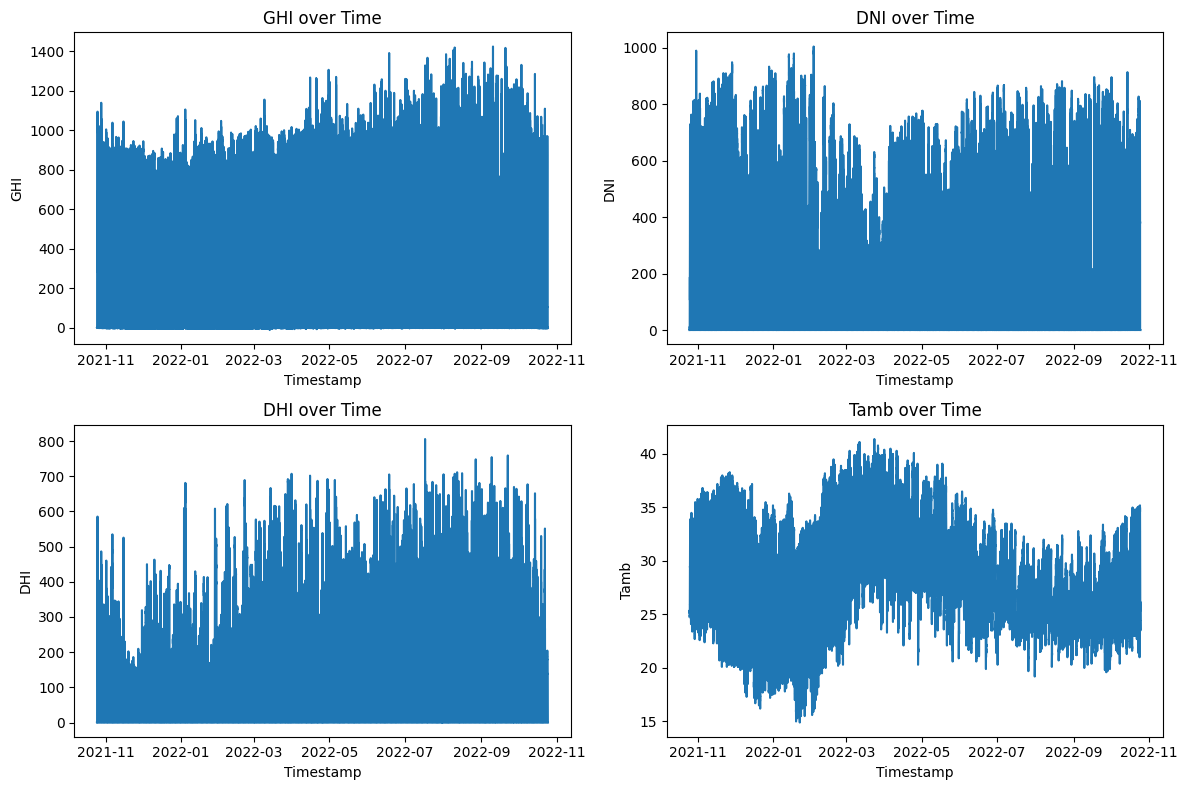

In [22]:
togo_df['Timestamp'] = pd.to_datetime(togo_df['Timestamp'])


plt.figure(figsize=(12, 8))


plt.subplot(2, 2, 1)
sns.lineplot(x='Timestamp', y='GHI', data=togo_df)
plt.title('GHI over Time')


plt.subplot(2, 2, 2)
sns.lineplot(x='Timestamp', y='DNI', data=togo_df)
plt.title('DNI over Time')


plt.subplot(2, 2, 3)
sns.lineplot(x='Timestamp', y='DHI', data=togo_df)
plt.title('DHI over Time')


plt.subplot(2, 2, 4)
sns.lineplot(x='Timestamp', y='Tamb', data=togo_df)
plt.title('Tamb over Time')

plt.tight_layout()
plt.show()

correlation analysis plots

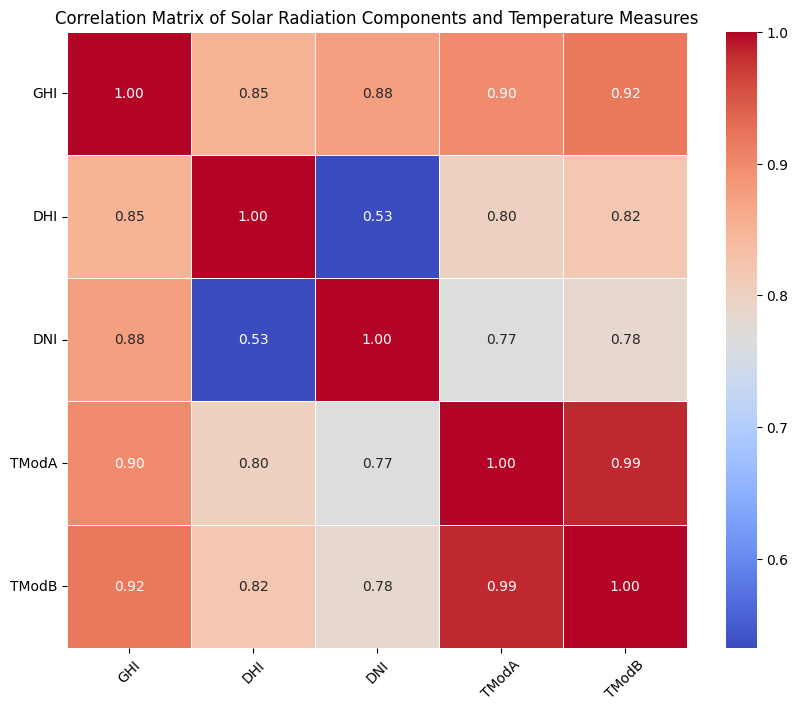

In [23]:
columns_of_interest = ['GHI', 'DHI', 'DNI', 'TModA', 'TModB']
dataset_subset = togo_df[columns_of_interest]


correlation_matrix = dataset_subset.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Solar Radiation Components and Temperature Measures')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

wind analysis

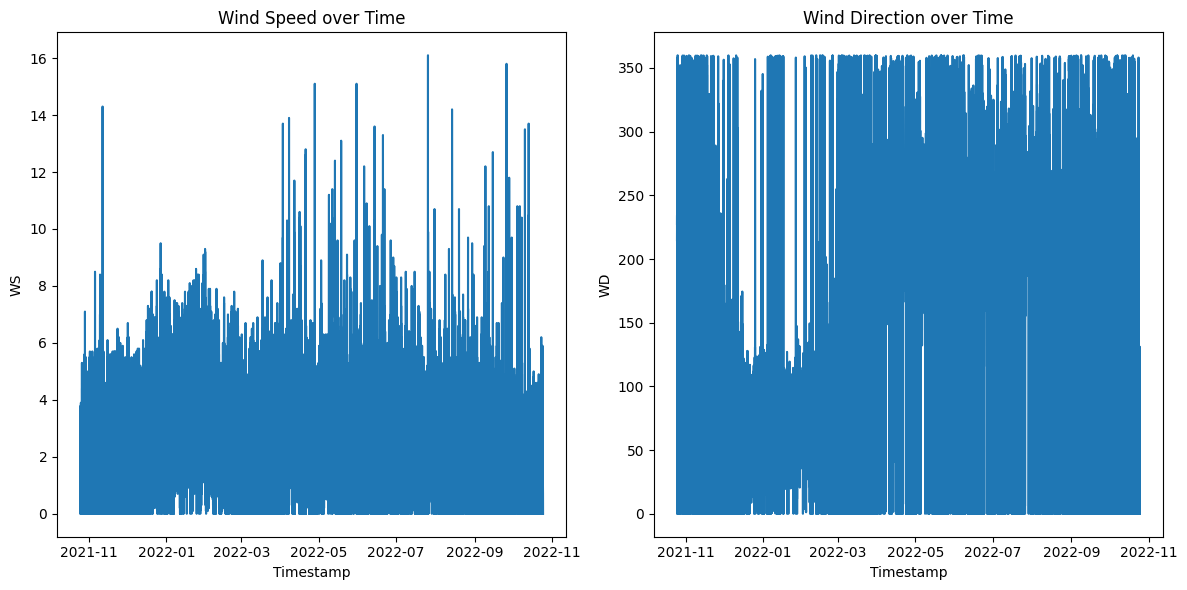

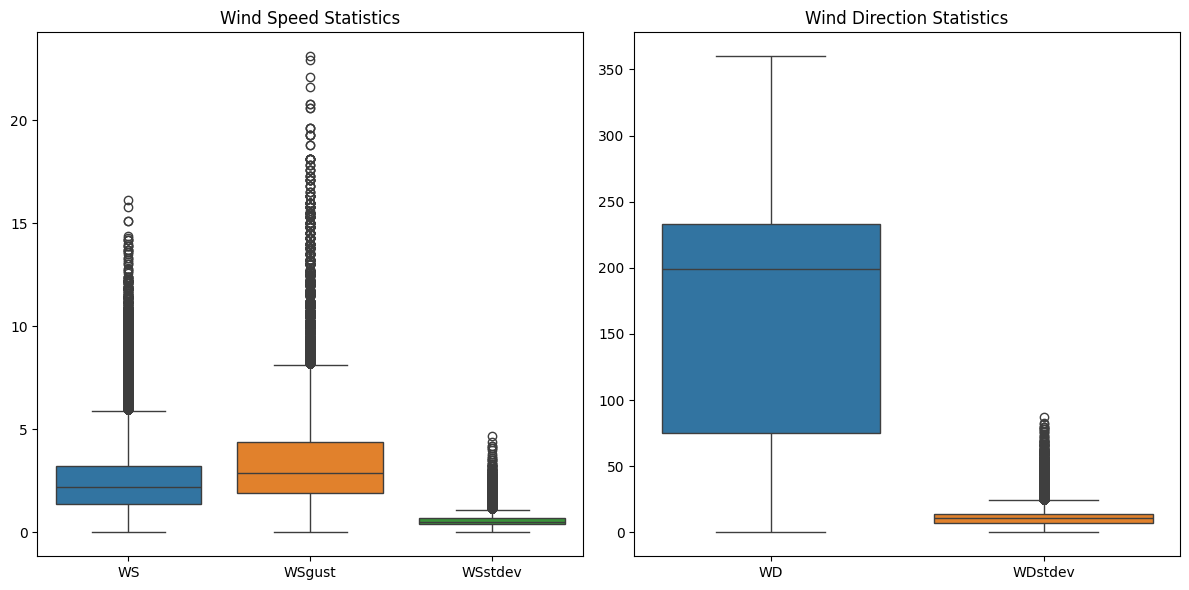

In [24]:
wind_columns = ['WS', 'WSgust', 'WSstdev', 'WD', 'WDstdev']
dataset_wind = togo_df[wind_columns]


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.lineplot(x='Timestamp', y='WS', data=togo_df)
plt.title('Wind Speed over Time')


plt.subplot(1, 2, 2)
sns.lineplot(x='Timestamp', y='WD', data=togo_df)
plt.title('Wind Direction over Time')

plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=dataset_wind[['WS', 'WSgust', 'WSstdev']], orient='v')
plt.title('Wind Speed Statistics')


plt.subplot(1, 2, 2)
sns.boxplot(data=dataset_wind[['WD', 'WDstdev']], orient='v')
plt.title('Wind Direction Statistics')

plt.tight_layout()
plt.show()

Tempurature Analysis plot

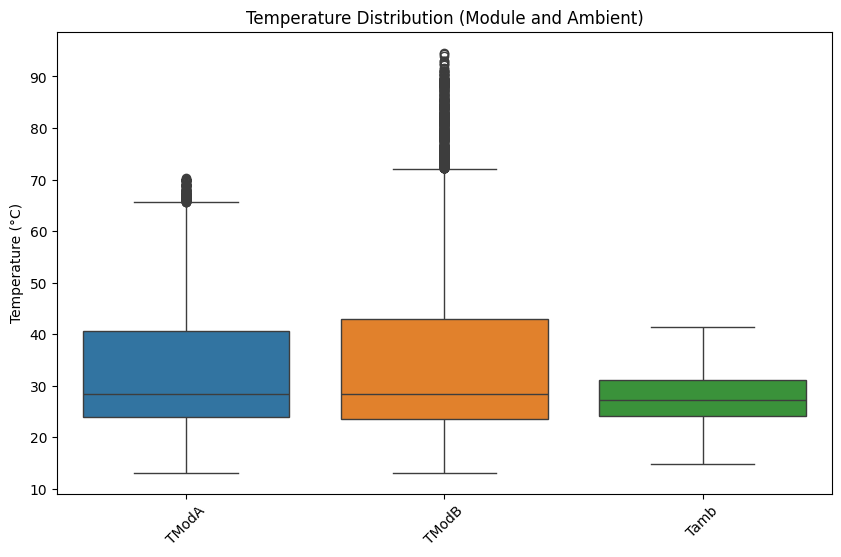

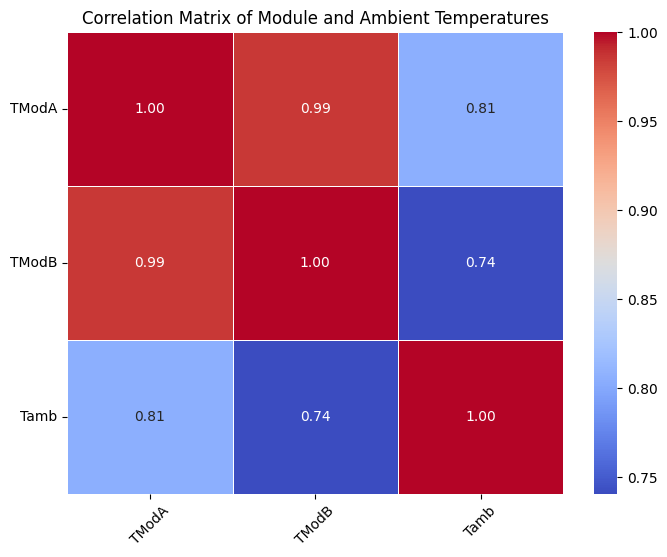

In [26]:
temperature_columns = ['TModA', 'TModB', 'Tamb']
dataset_temperatures = togo_df[temperature_columns]


plt.figure(figsize=(10, 6))
sns.boxplot(data=dataset_temperatures, orient='v')
plt.title('Temperature Distribution (Module and Ambient)')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.show()


plt.figure(figsize=(8, 6))
sns.heatmap(dataset_temperatures.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Module and Ambient Temperatures')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()